In [2]:
import pandas as pd
import numpy as np

In [25]:
dfr = pd.read_csv ('20190712_app_store_reviews_recent.csv')
dfh = pd.read_csv ('20190712_app_store_reviews_helpful.csv')

In [26]:
# Only want reviews.  These are entry.x.content.0.__text columns
dfr = dfr.loc[:, dfr.columns.str.contains('content.0.__text|.rating.__text')]
dfh = dfh.loc[:, dfh.columns.str.contains('content.0.__text|.rating.__text')]

In [27]:
# Transpose before concatenating
dfr = dfr.transpose()
dfh = dfh.transpose()


In [28]:
#putting the reviews in one column and the ratings in another
dfr = pd.DataFrame({'review':dfr[0].iloc[::2].values, 'rating':dfr[0].iloc[1::2].values})
dfh = pd.DataFrame({'review':dfh[0].iloc[::2].values, 'rating':dfh[0].iloc[1::2].values})

In [29]:
#Exporting the most helpful and the most recent will surely have duplicates
df = pd.concat([dfr,dfh]).drop_duplicates().reset_index(drop=True)

In [30]:
# Split good reviews (4 and 5 stars) and bad reviews (1 and 2 stars)
good = df.loc[df['rating'].isin([4,5])]
bad = df.loc[df['rating'].isin([1,2])]

## NLP 

In [38]:
from gensim.utils import simple_preprocess

import nltk
from nltk.corpus import stopwords
from nltk.util import bigrams
from nltk import FreqDist, Text
from nltk.stem import PorterStemmer

In [39]:
from collections import Counter
import operator
import matplotlib.pyplot as plt

In [40]:
Apple_good = good['review']
Apple_bad = bad['review']

In [41]:
def sentiment (review_df):

    t = review_df.str.cat(sep=' ')
    stop_words = stopwords.words('english') 
    
    def remove_stopwords(texts):
        return [word for word in simple_preprocess(str(texts)) if word not in stop_words] 

    words_nostops = remove_stopwords(t)
    words_bigrams = (list(bigrams(words_nostops)))
    words = words_nostops + words_bigrams

    def get_afinn_scores(file = 'AFINN-en-165.txt'): 
        afinn_file = open(file)
        scores = {}
        for line in afinn_file:
          term, score  = line.split("\t")
          scores[term] = int(score)
        return scores

    afinn_scores = get_afinn_scores()
    pos=[]
    for word in words:
        if word in afinn_scores and afinn_scores[word] > 0:
            pos.append(word)

    neg=[]
    for word in words:
        if word in afinn_scores and afinn_scores[word] < 0:
            neg.append(word)

    posneg = pos + neg

    count_pos = Counter(pos)
    count_neg = Counter(neg)
    count_posneg = Counter(posneg)

    freq_pos = {k: v for k,v in count_pos.items() if v > 1}
    freq_neg = {k: v for k,v in count_neg.items() if v > 1}
    freq_posneg = {k: v for k,v in count_posneg.items() if v > 1}

    sorted_freq_pos = dict( sorted(freq_pos.items(), key=operator.itemgetter(1),reverse=False))
    sorted_freq_neg = dict( sorted(freq_neg.items(), key=operator.itemgetter(1),reverse=False))
    sorted_freq_posneg = dict( sorted(freq_posneg.items(), key=operator.itemgetter(1),reverse=False))
    return [sorted_freq_pos, sorted_freq_neg, sorted_freq_posneg]
    

In [43]:
Apple_good_sentiment = sentiment(Apple_good)
Apple_good_pos = Apple_good_sentiment[0]
Apple_good_neg = Apple_good_sentiment[1]
Apple_good_posneg = Apple_good_sentiment[2]

In [44]:
Apple_bad_sentiment = sentiment(Apple_bad)
Apple_bad_pos = Apple_bad_sentiment[0]
Apple_bad_neg = Apple_bad_sentiment[1]
Apple_bad_posneg = Apple_bad_sentiment[2]

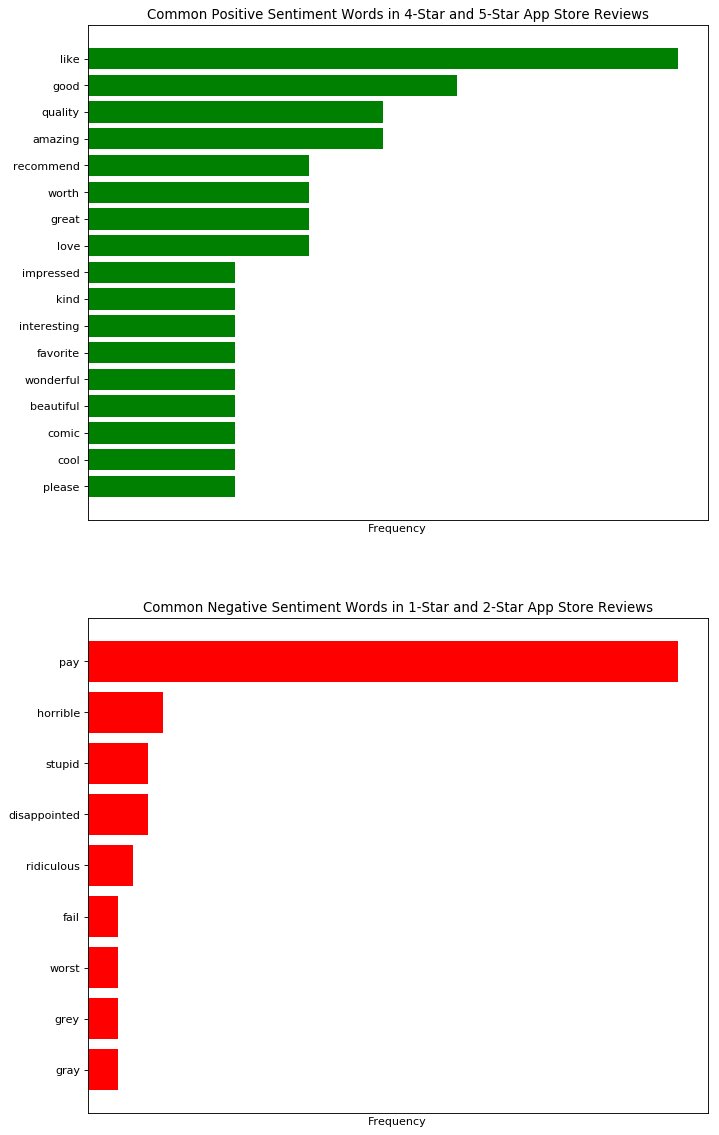

In [45]:
#All to get the axes the same 
#height_posneg = list(Google_good_posneg.values())
#bars_posneg = list(Google_good_posneg.keys())
#y_posneg = np.arange(len(bars_posneg))

#Good_pos
height_pos = list(Apple_good_pos.values())
bars_pos = list(Apple_good_pos.keys())
y_pos = np.arange(len(bars_pos))

#Bad_pos
height_neg = list(Apple_bad_neg.values())
bars_neg = list(Apple_bad_neg.keys())
y_neg = np.arange(len(bars_neg))

#indices to get the y values/position of each list
#idp = [ bars_posneg.index(b) for b in bars_pos ]
#ign = [ bars_posneg.index(b) for b in bars_neg ]

#Make plot bigger than default
plt.figure (figsize=(10, 18), dpi= 80)

plt.figure(1)
plt.subplot(211)

# Create horizontal bars
plt.barh(y_pos, height_pos, color = 'green', label = 'Positive Sentiment')
# Create names on the y-axis
plt.yticks(y_pos, bars_pos)
plt.xticks([])
plt.xlabel ('Frequency')
plt.title('Common Positive Sentiment Words in 4-Star and 5-Star App Store Reviews')
#plt.legend()

plt.subplot(212)
plt.barh(y_neg, height_neg, color = 'red', label = 'Negative Sentiment')
# Create names on the y-axis
plt.yticks(y_neg, bars_neg)
plt.xticks([])
plt.xlabel ('Frequency')
plt.title('Common Negative Sentiment Words in 1-Star and 2-Star App Store Reviews')

#plt.legend()

# Show graphic
plt.show()